## Khomkin Konstantin, cohort 53DS
Numerical Methods Project, v.2.0 08.02.2023

## Introduction
The aim of the project is to find an optimal model for determining the value of a used car based on historical data: technical characteristics, equipment and price.


# Determining the vehicles' prices

The service for the sale of used cars "No accidents, not painted" is developing an application to attract new customers. In it, you can quickly find out the market value of your car. You have historical data at your disposal: technical characteristics, equipment and prices of cars. You need to build a model to determine the value. 

The customer is interested in:

- quality of prediction;
- speed of prediction;
- training time.

## Importing libraries, loading and preprocessing data

In [1]:
# Pandas:
import pandas as pd # we need the Pandas library to work with the dataset

# Numpy:
import numpy as np # we need the numpy library to work with math functions 
#import numpy.matlib # we need the matlib library to work with math functions. 

# Sklearn:
from sklearn.model_selection import train_test_split # train_test_split function we need to split the data into samples
from sklearn.tree import DecisionTreeRegressor # Decision Tree model. 
from sklearn.linear_model import LinearRegression # "Linear Regression" model 
from sklearn.ensemble import RandomForestRegressor # "Random Forest" model from sklearn.preprocessing import StandardScaler # data scale standardization method
from sklearn.metrics import mean_squared_error # method for calculating RMSE and vtnhbrb RMSE
from sklearn.preprocessing import StandardScaler # method to standardize data scale
from sklearn.preprocessing import OneHotEncoder # method to encode categorical features
from sklearn.exceptions import DataConversionWarning
   

# Mathlotlib:

import matplotlib as plt

# seaborn
import seaborn as sns


# LightGBM:
from lightgbm import LGBMRegressor

# Warnings
import warnings

# timeit 
import timeit # for timing training and model prediction

In [2]:
# apply the try-except construct to load the file both for the local version and for working from the simulator

try:

    df = pd.read_csv('autos.csv')
except:

    df = pd.read_csv('/datasets/autos.csv') 

In [3]:
df.head(5) # let's look at the structure of the raw data

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df.shape # ... and at the size of the dataframe

(354369, 16)

In [6]:
# keep the number of original rows
str_count = df.shape[0]
str_count

354369

Brief conclusions:
1. There are gaps in the data.
2. data types need to be summarized.
3. at first glance there are columns with redundant data (number of pictures, postal code), perhaps some of the dates are superfluous, the type of vehicle is not fundamental, if there is a make and model.


Let's analyze all the signs available to us from the information from the customer and select a group of signs that affect the estimated value of the vehicle, and do not affect:

Signs that affect the evaluation value in their meaning:<br>
**VehicleType** — car body type<br>
**RegistrationYear** — the year of registration of the car (here we make the assumption that this is the year **of the first registration**)<br>
**Gearbox** — type of gearbox<br>
**Power** — power (hp)<br>
**Model** — car model<br>
**Kilometer** — mileage (km)<br>
**FuelType** — fuel type<br>
**Brand** — car brand<br>
**Repaired** — was the car under repair or not<br><br><br>

Features that do not affect in their meaning the estimated value of the object of evaluation (vehicle):<br>
**DateCrawled** — date of downloading the questionnaire from the database<br>
**RegistrationMonth** — month of registration of the car<br>
**DateCreated** — date of creation of the questionnaire<br>
**NumberOfPictures** — number of photos of the car<br>
**PostalCode** — postal code of the questionnaire owner (user)<br>
**lastSeen** — date of the last user activity<br>

Remove the signs from the second list

In [7]:
df = df.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

In [8]:
df.head(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [9]:
df.duplicated().sum() # проверим данные на полные дубликаты

45040

There are more than 45 thousand complete duplicates, which is about 13% of the original dataset. For training tasks, these duplicates will not bring any benefit, so we delete the complete duplicates

In [10]:
df = df.drop_duplicates()

The critical characteristic of the object is the model, the "Model" column. Without information about the model, the estimate does not make sense. For example, an entry in the Toyota database without specifying a specific model, even if there is information about mileage, body type, year of manufacture, will not increase the accuracy of the evaluation model in any way, even rather reduce it by introducing an error. In the line of one manufacturer there can be both super-budget and expensive models.

Thus, we delete all lines with omissions in the "Model" column

In [11]:
df = df.dropna(subset = ['Model'], axis='rows') 

Another critical column is information about whether the object has been repaired. Let's assume that if there is no repair information in the column, the object was not repaired. Thus, fill in the gaps in the "Repaired" column with the value "no"

In [12]:
df['Repaired'] = df['Repaired'].fillna(value = 'no') 

In [13]:
#df.info()

Consider the columns "VehicleType", "Gearbox" and "FuelType":
Output a list of unique values

In [14]:
print('тип ТС:', set(df['VehicleType']))
print('КПП:', set(df['Gearbox']))
print('топливо', set(df['FuelType']))

тип ТС: {nan, 'small', 'coupe', 'bus', 'wagon', 'sedan', 'convertible', 'other', 'suv'}
КПП: {'manual', nan, 'auto'}
топливо {nan, 'hybrid', 'gasoline', 'lpg', 'electric', 'petrol', 'other', 'cng'}


Great, there is a type of vehicle and fuel "other" - replace the omissions with this value.

In [15]:
df['VehicleType'] = df['VehicleType'].fillna(value = 'other') 
df['FuelType'] = df['FuelType'].fillna(value = 'other') 

The gaps in the "Gearbox" column are more difficult, let's look at the distribution of values:

In [16]:
print(df['Gearbox'].value_counts())
print(df['Gearbox'].isna().sum())

manual    220960
auto       56255
Name: Gearbox, dtype: int64
13753


So, there is a choice: either delete 13.7 thousand lines that do not have information about the type of checkpoint, or replace the omissions with a more frequent value "manual". Let's see what is the percentage of lines with omissions:

In [17]:
print(f"Пропусков в строке КПП, {df['Gearbox'].isna().sum()/df['Gearbox'].count()*100:.2f}%" )


Пропусков в строке КПП, 4.96%


We make a decision - to donate 5% of the data and delete rows with missing data in the "Gearbox" column

In [18]:
df = df.dropna(subset = ['Gearbox'], axis='rows') 

we will also check the data for the presence of implicit duplicates:

In [19]:
for column in ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']:
    print(df[column].value_counts())

sedan          73398
small          61745
wagon          53095
other          24744
bus            24229
convertible    16761
coupe          13441
suv             9802
Name: VehicleType, dtype: int64
manual    220960
auto       56255
Name: Gearbox, dtype: int64
golf                  22478
other                 21584
3er                   16181
polo                   9871
corsa                  9050
astra                  8960
a4                     8046
passat                 7996
c_klasse               6954
5er                    6516
e_klasse               5872
a3                     5045
focus                  4925
fiesta                 4758
a6                     4728
2_reihe                4036
transporter            3999
twingo                 3623
vectra                 3555
a_klasse               3543
fortwo                 3219
3_reihe                3036
mondeo                 3019
1er                    3009
clio                   2940
touran                 2728
punto     

We output the final information about the dataset with which it will work

In [20]:
df.info()

TypeError: Cannot interpret '<attribute 'dtype' of 'numpy.generic' objects>' as a data type

After importing the data, we saved the initial number of entries in the dataset in the str_count variable.
let's see what% of the data we deleted in preprocessing

In [21]:
print(f"От первоначального датасета осталось {df.shape[0]/str_count*100:.2f}% записей")

От первоначального датасета осталось 78.23% записей


### Intermediate output:
Data import and preprocessing were carried out. Non-informative signs that do not affect the estimated value of the object of assessment (vehicle) in their meaning have been removed:<br>
**DateCrawled** — date of downloading the questionnaire from the database<br>
**RegistrationMonth** — month of registration of the car<br>
**DateCreated** — date of creation of the questionnaire<br>
**NumberOfPictures** — number of photos of the car<br>
**PostalCode** — postal code of the questionnaire owner (user)<br>
**lastSeen** — date of the last user activity<br>

The gaps in the columns are filled in:<br>
**VehicleType** — car body type<br>
**FuelType** — fuel type<br>

Removed the omission in the column: <br>
**Gearbox** — type of gearbox<br>

Full duplicates have been removed, and a check for hidden duplicates has been carried out.

From the original dataset, **78.23%** of records have been preserved

In [22]:
df['Price'].plot(kind='hist', bins=20) # Building a histogram of the price distribution.

TypeError: Cannot interpret '<attribute 'dtype' of 'numpy.generic' objects>' as a data type

Interestingly, there are a lot of "very cheap" offers, consider the range "up to 500 euros" in more detail

Obviously, a spike in zero-price data is a mistake.

In [24]:
df[df['Price']<50]['Price'].count() # let's count the number of rows with a "near-zero" price

6837

These 6,9 thousand records will have to be sacrificed, they are clearly erroneous.

In [25]:
df= df[df['Price'] > 50] # we leave entries with a price of more than 50 euros

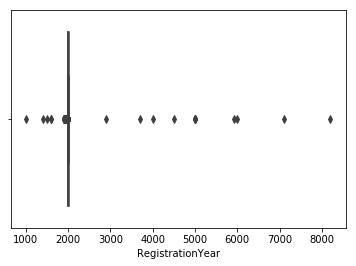

In [27]:
sns.boxplot(df['RegistrationYear'])#Building a boxplot for the year of registration

Obviously, there cannot be years of registration before 1768 (the year of the invention of the car) and after 2023, all emissions are errors. Let's count their number

In [28]:
df[(df['RegistrationYear']>2023) | (df['RegistrationYear']<1768) ]['RegistrationYear'].count() # подсчитаем количество строк с "аномальными" годами регистрации

18

there are only 18 such anomalies, we remove these artifacts without hesitation

In [29]:
df = df[ (df['RegistrationYear'] <= 2023) & (1768 <= df['RegistrationYear']) ] # удаляем записи с аномальными годами выпуска

In [ ]:
df.info()

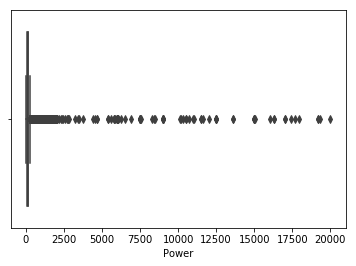

In [30]:
sns.boxplot(df['Power'])#Building a boxplot of engine power distribution

A lot of emissions, according to the Network, the minimum power of an automobile engine is 0.75 hp (one of the first cars of Karl Benz), the maximum registered is 5000 hp. Everything above / below is removed immediately, and what is in the range of 1700-5000 we will check whether the data of the rating of the most powerful cars https://cars-rating.ru/legkovye/samye-moshhnye-avtomobili-v-mire

In [31]:
df[(df['Power']>5000) | (df['Power']<0.75) ]['Power'].count() # подсчитаем количество строк с "аномальными" мощностями

20589

20.5 thousand lines is a lot, but there is no adequate and unambiguous way to correct this error (the power could be confused with the price, they could indicate the power in Watts instead of HP, etc.) The lines must be deleted.

In [32]:
df = df[ (df['Power'] <= 5000) & (0.75 <= df['Power']) ] # deleting records with abnormal release years

In [33]:
df[df['Power']>1000]['Power'].count() # let's see how many potentially exclusive sports cars we have with a capacity of 1000-5000 hp

167

In [34]:
 print(df[df['Power']>1000]['Model'].value_counts()) # let's output a list of unique models among these 

3er            11
golf           11
passat         10
vectra         10
astra           9
other           7
transporter     7
polo            6
c_klasse        6
e_klasse        5
a_klasse        4
focus           4
scenic          4
a4              4
5er             4
zafira          4
a6              3
corsa           3
touran          2
v40             2
ka              2
toledo          2
galaxy          2
mondeo          2
3_reihe         2
tt              2
micra           2
laguna          2
twingo          2
cooper          2
stilo           2
1er             1
kangoo          1
yaris           1
rio             1
ibiza           1
sprinter        1
outlander       1
kaefer          1
c5              1
clio            1
x_trail         1
c4              1
a3              1
6_reihe         1
punto           1
ypsilon         1
touareg         1
escort          1
berlingo        1
a8              1
nubira          1
tiguan          1
fiesta          1
octavia         1
rav       

Obviously, there is not a single exclusive sports car among Golfs, Fiestas and other Sprinters. This means that these records are also erroneous and must be deleted.

In [35]:
df = df[ df['Power'] <= 1000 ] # deleting records with abnormal capacities

In [ ]:
df.info()

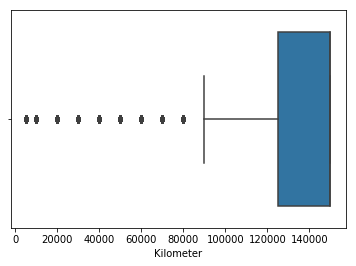

In [36]:
sns.boxplot(df['Kilometer']) #Building a boxplot of mileage distribution

There are no anomalies here. It's even strange that there are no runs of a million kilometers, this happens in life.

In [37]:
print(f"От первоначального датасета осталось {df.shape[0]/str_count*100:.2f}% записей")

От первоначального датасета осталось 70.39% записей


## Models learning

In [38]:
features = df.drop(['Price'], axis=1) # extracting features
target = df['Price'] # extracting the target attribute

In [39]:
features.head()


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
2,suv,2004,auto,163,grand,125000,gasoline,jeep,no
3,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no


In [40]:
features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features, target, test_size=0.4, random_state=12345) 
# we separate 40% of the data for a "validation-test" sample using stratify to maintain the balance of classes

In [41]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_test, target_valid_test, test_size=0.5, random_state=12345) 
# divide "valid_test" in half into "validation" and "test" samples using stratify to maintain class balance

In [42]:
# for the sake of conciseness of the code, we keep the names of categorical features in a separate list
text_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired'] 

In [43]:
#we select columns with categorical features from the selection
features_train_text = features_train[text_columns]
features_valid_text = features_valid[text_columns]
features_test_text  = features_test[text_columns]

In [44]:
# Declaring the OneHotEncoder method

encod = OneHotEncoder()

In [45]:
# We train the method on categorical columns of the training sample
encod.fit(features_train_text)

OneHotEncoder()

In [46]:
# Apply coding to categorical columns of all samples
enc_data_train = pd.DataFrame(encod.transform(features_train_text).toarray())
enc_data_valid = pd.DataFrame(encod.transform(features_valid_text).toarray())
enc_data_test  = pd.DataFrame(encod.transform(features_test_text).toarray())



In [47]:
# # Replace categorical columns with encoded columns in the initial feature samples, apply drop and join:
features_train = features_train.drop(text_columns, axis=1)
features_valid = features_valid.drop(text_columns, axis=1)
features_test  = features_test.drop(text_columns, axis=1)


features_train = features_train.join(enc_data_train)
features_valid = features_valid.join(enc_data_valid)
features_test  = features_test.join(enc_data_test)

In [48]:
features_train.head()

,RegistrationYear,Power,Kilometer,0,1,2,3,4,5,6,...,297,298,299,300,301,302,303,304,305,306
52129,2004,75,100000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
119140,2012,122,60000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
69403,1996,45,150000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
107935,2010,105,125000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
141712,1996,72,150000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [49]:
features_valid.head()

,RegistrationYear,Power,Kilometer,0,1,2,3,4,5,6,...,297,298,299,300,301,302,303,304,305,306
151979,2003,90,150000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
347864,2000,279,150000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165143,1997,54,150000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1607,2000,115,125000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
173638,1995,60,90000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
features_test.head()

,RegistrationYear,Power,Kilometer,0,1,2,3,4,5,6,...,297,298,299,300,301,302,303,304,305,306
89785,2008,177,150000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179608,1996,45,150000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
272970,2005,68,150000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
139120,2005,116,150000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254017,2005,140,150000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
features_test.head()

,RegistrationYear,Power,Kilometer,0,1,2,3,4,5,6,...,297,298,299,300,301,302,303,304,305,306
89785,2008,177,150000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179608,1996,45,150000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
272970,2005,68,150000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
139120,2005,116,150000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254017,2005,140,150000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
# For correct training of models, fill in NaN with zeros:
features_train = features_train.fillna(0)
features_valid = features_valid.fillna(0)
features_test = features_test.fillna(0)

In [53]:
# Define missing columns in features_test
missing_cols = set( features_train.columns ) - set( features_test.columns )

# Add missing columns to features_test and fill them with zeros
for c in missing_cols:
    features_test[c] = 0
    
# Make sure that the column order in features_test is the same as in the training sample
features_test = features_test[features_train.columns]



# Define missing columns in features_valid
missing_cols = set( features_train.columns ) - set( features_valid.columns )

# Add the missing columns to features_valid and fill them with zeros
for c in missing_cols:
    features_valid[c] = 0
    
# Make sure that the column order in features_valid is the same as in the training sample
features_valid = features_valid[features_train.columns]



In [54]:
# Проведем масштабирование признаков

#отключаем предупреждения о преобразованиях типов данных
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
scaler = StandardScaler() # объявляем метод

scaler.fit(features_train.astype(float)) # Обучаем метод только на обучающей выборке
features_train = pd.DataFrame(scaler.transform(features_train), columns=features_train.columns) # Преобразуем данные и сохраняем в новой переменной в структуре DataFrame()
features_valid = pd.DataFrame(scaler.transform(features_valid), columns=features_valid.columns) # Преобразуем данные и сохраняем в новой переменной в структуре DataFrame()
features_test = pd.DataFrame(scaler.transform(features_test), columns=features_test.columns) # Преобразуем данные и сохраняем в новой переменной в структуре DataFrame()



MemoryError: Unable to allocate 354. MiB for an array with shape (310, 149655) and data type float64

Samples are prepared, categorical features are encoded by simple coding. Consider the models of linear regression, decision regressor, random forest regressor and LightGBM

In [55]:
models = {}

# Using the LinearRegression() model
models[0] = Linear regression()

# Choosing a decision-making method Treeregressor() with different
model parameters[1] = DecisionTreeRegressor(random_state=12345, max_depth = 5)
models[2] = DecisionTreeRegressor(random_state=12345, max_depth = 10)
models[3] = DecisionTreeRegressor(random_state=12345, max_depth = 15)

# Choosing the RandomForestRegressor() method with different
model parameters[4] = RandomForestRegressor(random_state=12345, n_estimators=15, max_depth = 5)
models[5] = RandomForestRegressor(random_state=12345, n_estimators=25, max_depth = 5)
models[6] = RandomForestRegressor(random_state=12345, n_estimators=25, max_depth = 15)

# We are a LGBT regressor modeler() with different hyperparameters
of the model[7] = LGBMRegressor(random_state=12345, n_estimators=15, max_depth = 5)
models[8] = LGBMRegressor(random_state=12345, n_estimators=25, max_depth = 5)
models[9] = LGBMRegressor(random_state= 12345, n_estimators=25, max_depth = 15)

SyntaxError: invalid syntax (<ipython-input-55-75b46f34966c>, line 4)

The models have been announced, we will take measurements of the time for training

In [ ]:
# In the loop, we iterate through all the models and measure the training time of each, adding the results to the TrainTime variable

TrainTime = {}

for i in range(len(models)):
    start_time = timeit.default_timer()
    models[i].fit(features_train, target_train)
    TrainTime[i] = timeit.default_timer() - start_time

In [ ]:
TrainTime

**Intermediate output:** The models have been trained, the time for training each model has been measured.<br>
**NB:** The hyperparameters of the models were chosen randomly, without lengthy GridSearch procedures to save time, since the project is educational and we do not pursue accuracy, but follow the methodology. In a real project, you can add a hyperparameter selection block for each model, which would require offhand one hour of time for each model.

## Model analysis

In [ ]:
# In the loop, we iterate through all the models, make a prediction and measure the prediction time of each
# # The results of the predictions are added to the Prediction_valid variable, the time measurements are stored in PredictTime

Prediction_valid = {}
PredictTime = {}

for i in range(len(models)):
    start_time = timeit.default_timer()
    Prediction_valid[i] = models[i].predict(features_valid)     
    PredictTime[i] = timeit.default_timer() - start_time

In [ ]:
PredictTime

In [ ]:
# In the loop, we iterate through all the models and calculate the RMSE metric, we will save the result in the variable of the same name
RMSE = {}

for i in range(len(models)):
    RMSE[i] = mean_squared_error(target_valid, Prediction_valid[i])**0.5     
    

In [ ]:
RMSE

**Interim summary:** Predictions were calculated for all models, time was fixed, the RMSE metric of each model was calculated.

Let's solve the main problem: we will choose the "optimal" model based on the criterion "the best training time, prediction time and model quality".
The best model with such introductory data is the one that will show less training time, less prediction time and less standard deviation. Let's find the minimum value of the product of three results - learning time, prediction time and RMSE.

In [ ]:
# Find the product of three results - learning time, prediction time and RMSE.
result = {}
for i in range(len(models)):
    result[i] = TrainTime[i] * PredictTime[i] * RMSE[i]

In [ ]:
result

In [ ]:
# Let's determine which model gave the best result according to our criterion:
models[list(result.keys())[list(result.values()).index(min(result.values()))]]

**Interim summary:** The optimal model was "DecisionTreeRegressor()" with the hyperparameter max_depth=5
Now let's evaluate the quality of this model on a test sample

In [ ]:
# To make the entries more concise, let's define the key number of the optimal model
key = list(result.keys())[list(result.values()).index(min(result.values()))]
key

In [ ]:
predictions_best = models[key].predict(features_test) # prediction by test sampling
score_best = mean_squared_error(target_test, predictions_best)**0.5 # calculation of the RMSE metric
score_best

The RMSE metric on the test sample is comparable to the validation result.

**Intermediate output:** The selected model '#1' showed far from the best, but not the worst result.  At the same time, the model learns quickly and predicts quickly. <br> Comparison with other models here replaces the adequacy check with the use of a constant model.

# Conclusions
In the project, the task was to find the optimal model for determining the value of a used car based on historical data: technical characteristics, configuration and prices.<br>
At the same time, the customer formulated clear optimality criteria - the speed of learning and prediction with good quality.<br>

At the stage of preliminary data processing, both omissions and data that are not valuable for calculations (for example, the number of photos or the date of publication) were identified.
After processing the omissions, 78% of the original data was saved.

The project analyzed regression models "Linear regression" (one model), "Random Forest" (three sets of hyperparameters), "Decision Tree" (three sets of hyperparameters) and "regression with gradient boosting" (three sets of hyperparameters).<br>
Timekeeping of the learning processes of each model (with different hyperparameters), the processes of obtaining predictions were performed, and the calculation of the quality metric of each model (RMSE metric) was performed. A total of 10 model variants were analyzed.<br><br>

Based on the customer's requirements, an optimal model was determined (based on minimizing the product of the training time, prediction time and quality metric), which turned out to be a "Decision Tree" model with the "maximum depth" hyperparameter equal to 5.

This model was applied to a test sample and the RMSE metric was 2551 .<br>
<br>
<br><br>
An important conclusion: when searching for the optimal model, taking into account the calculation time, the most accurate model will not always be optimal. And not always the fastest. Probably, with more accurate introductory weights of criteria, it would be possible to choose a more accurate model with comparable time. To do this, we would need conditions like "a model that learns and predicts no longer than XX seconds and provides the first quartile in quality based on the so-and-so metric."